# Система детекции реальных тревог электросамокатов


## DB connection

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime

# Загрузка переменных окружения
load_dotenv()

# Подключение к БД
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")

db_url = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(db_url)

# Пути
os.makedirs("data", exist_ok=True)
csv_path = "data/incidents.csv"
timestamp_file = "data/last_timestamp.txt"

# Получение последнего timestamp
if os.path.exists(timestamp_file):
    with open(timestamp_file, "r") as f:
        last_timestamp = f.read().strip()
        print(f"Последний timestamp из файла: {last_timestamp}")
else:
    # Если файл не найден — загружаем всё после определенного ID (например, 10000)
    last_timestamp = None
    print("Файл с timestamp не найден, загружаем с начала")

# Параметры батчей
batch_size = 1000
offset = 0
total_rows_fetched = 0
batches = []

# Чтение батчей
while True:
    if last_timestamp:
        query = f"""
            SELECT * FROM public.incident
            WHERE timestamp > '{last_timestamp}'
            ORDER BY timestamp ASC
            LIMIT {batch_size} OFFSET {offset};
        """
    else:
        query = f"""
            SELECT * FROM public.incident
            WHERE id > 10000
            ORDER BY timestamp ASC
            LIMIT {batch_size} OFFSET {offset};
        """

    batch_df = pd.read_sql_query(query, engine)

    rows = len(batch_df)
    if rows == 0:
        break

    batches.append(batch_df)
    print(f"Загружено {rows} строк (offset={offset})")

    total_rows_fetched += rows
    offset += batch_size

# Если что-то выгрузилось — сохраняем
if batches:
    raw_data = pd.concat(batches, ignore_index=True)

    # Добавление в конец CSV или создание нового
    if os.path.exists(csv_path):
        raw_data.to_csv(csv_path, mode="a", index=False, header=False)
    else:
        raw_data.to_csv(csv_path, index=False)

    # Обновляем last_timestamp
    new_last_timestamp = raw_data["timestamp"].max()
    with open(timestamp_file, "w") as f:
        f.write(str(new_last_timestamp))

    print(f"Всего выгружено и сохранено: {total_rows_fetched} строк")
    print(f"Обновлённый последний timestamp: {new_last_timestamp}")
else:
    print("Новых данных не найдено")

Файл с timestamp не найден, загружаем с начала
Загружено 1000 строк (offset=0)
Загружено 1000 строк (offset=1000)
Загружено 1000 строк (offset=2000)
Загружено 1000 строк (offset=3000)
Загружено 1000 строк (offset=4000)
Загружено 1000 строк (offset=5000)
Загружено 1000 строк (offset=6000)
Загружено 1000 строк (offset=7000)
Загружено 1000 строк (offset=8000)
Загружено 1000 строк (offset=9000)
Загружено 1000 строк (offset=10000)
Загружено 1000 строк (offset=11000)
Загружено 1000 строк (offset=12000)
Загружено 1000 строк (offset=13000)
Загружено 1000 строк (offset=14000)
Загружено 1000 строк (offset=15000)
Загружено 1000 строк (offset=16000)
Загружено 1000 строк (offset=17000)
Загружено 1000 строк (offset=18000)
Загружено 1000 строк (offset=19000)
Загружено 1000 строк (offset=20000)
Загружено 1000 строк (offset=21000)
Загружено 1000 строк (offset=22000)
Загружено 1000 строк (offset=23000)
Загружено 1000 строк (offset=24000)
Загружено 1000 строк (offset=25000)
Загружено 1000 строк (offset=2

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime

# Загрузка переменных окружения
load_dotenv()

# Подключение к БД
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")

db_url = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(db_url)

# Пути
os.makedirs("data", exist_ok=True)
csv_path = "data/incidents.csv"
timestamp_file = "data/last_timestamp.txt"

# Получение последнего timestamp
if os.path.exists(timestamp_file):
    with open(timestamp_file, "r") as f:
        last_timestamp = f.read().strip()
        print(f"Последний timestamp из файла: {last_timestamp}")
    # Если нужно, приводим last_timestamp к нужному формату:
    # last_timestamp = pd.to_datetime(last_timestamp)
else:
    last_timestamp = None
    print("Файл с timestamp не найден, загружаем с начала")

batch_size = 1000
total_rows_fetched = 0

while True:
    if last_timestamp:
        # Если last_timestamp уже задан, берем строки после этого timestamp
        query = f"""
        SELECT id, timestamp, data, business_status
        FROM public.incident
        WHERE timestamp > '{last_timestamp}'
        ORDER BY timestamp
        LIMIT {batch_size}
        """
    else:
        # Если нет last_timestamp, пусть, к примеру, берем всё после id>10000
        # Или, если хотим именно по timestamp — можно задать какую-то нижнюю границу
        query = f"""
        SELECT id, timestamp, data, business_status
        FROM public.incident
        WHERE id > 10000
        ORDER BY timestamp
        LIMIT {batch_size}
        """

    batch_df = pd.read_sql_query(query, engine)

    rows = len(batch_df)
    if rows == 0:
        print("Новых данных не найдено — выходим из цикла.")
        break
    
    # Если csv еще не существует — пишем с заголовками, иначе — без них
    if not os.path.exists(csv_path):
        batch_df.to_csv(csv_path, index=False, mode='w', header=True)
    else:
        batch_df.to_csv(csv_path, index=False, mode='a', header=False)
    
    # Считаем общее кол-во
    total_rows_fetched += rows

    # Обновляем last_timestamp (максимальный из текущего батча)
    new_last_timestamp = batch_df["timestamp"].max()
    with open(timestamp_file, "w") as f:
        f.write(str(new_last_timestamp))

    print(f"Выгрузили батч из {rows} строк. Новый last_timestamp={new_last_timestamp}")
    
    # Для следующей итерации
    last_timestamp = new_last_timestamp

print(f"Всего выгружено: {total_rows_fetched} строк")


Последний timestamp из файла: 2025-04-01 12:35:59.575377


In [6]:
df = pd.read_csv('data/incidents_3_04.csv')

In [7]:
df.tail()

,id,timestamp,probability,data,alarm_id,tracker_id,business_status,status,incident_group,group_timestamp,user_id,probability_v2
5492,205493,2025-04-03 12:32:31.179121,0,"{'alarm_id': '67ee7fdc4739db8398da0091', 'iden...",67ee7fdc4739db8398da0091,S.090851,NaN,pending,NaN,NaN,NaN,NaN
5493,205494,2025-04-03 12:32:35.114024,14,"{'alarm_id': '67ee7fe17c25819b148a51a8', 'iden...",67ee7fe17c25819b148a51a8,S.131167,NaN,pending,NaN,NaN,NaN,NaN
5494,205495,2025-04-03 12:32:35.163951,0,"{'alarm_id': '67ee7fe1316dfcbb99f6da58', 'iden...",67ee7fe1316dfcbb99f6da58,S.090981,NaN,pending,NaN,NaN,NaN,NaN
5495,205496,2025-04-03 12:32:55.836140,0,"{'alarm_id': '67ee7ff623476a329779f3c9', 'iden...",67ee7ff623476a329779f3c9,S.067698,NaN,pending,NaN,NaN,NaN,NaN
5496,205497,2025-04-03 12:33:10.322716,2,"{'alarm_id': '67ee800474785cbc4a581496', 'iden...",67ee800474785cbc4a581496,S.475949,NaN,pending,NaN,NaN,NaN,NaN


## Parsing data

In [1]:
import pandas as pd

In [66]:
df = pd.read_csv("data/incidents2.csv")
# df = raw_data

KeyboardInterrupt: 

In [3]:
df.()

,id,timestamp,probability,data,alarm_id,tracker_id,business_status,status,incident_group,group_timestamp,user_id,probability_v2
97442,107447,2025-03-27 15:05:45.551585,2,"{'alarm_id': '67e56948e021a37a0c3d4f69', 'iden...",67e56948e021a37a0c3d4f69,S.246173,NaN,pending,NaN,NaN,NaN,NaN
97443,107448,2025-03-27 15:05:47.224232,22,"{'alarm_id': '67e5694a145a6f5649377079', 'iden...",67e5694a145a6f5649377079,S.488110,NaN,pending,NaN,NaN,NaN,NaN
97444,107449,2025-03-27 15:05:47.636048,0,"{'alarm_id': '67e5694abe5d625ca26b5a38', 'iden...",67e5694abe5d625ca26b5a38,S.139638,NaN,pending,NaN,NaN,NaN,NaN
97445,107450,2025-03-27 15:05:48.943550,51,"{'alarm_id': '67e5694c840e8e88dd84ec6d', 'iden...",67e5694c840e8e88dd84ec6d,S.120189,NaN,pending,NaN,NaN,NaN,NaN
97446,107451,2025-03-27 15:06:00.371723,1,"{'alarm_id': '67e569561302b02c359b1b5d', 'iden...",67e569561302b02c359b1b5d,S.197989,NaN,pending,NaN,NaN,NaN,NaN


In [4]:
df["data"].tail()

97442    {'alarm_id': '67e56948e021a37a0c3d4f69', 'iden...
97443    {'alarm_id': '67e5694a145a6f5649377079', 'iden...
97444    {'alarm_id': '67e5694abe5d625ca26b5a38', 'iden...
97445    {'alarm_id': '67e5694c840e8e88dd84ec6d', 'iden...
97446    {'alarm_id': '67e569561302b02c359b1b5d', 'iden...
Name: data, dtype: object

#### Общие основные поля в data

- **alarm_id**: Это уникальный идентификатор тревоги, связанной с инцидентом. Он используется для связи инцидента с конкретной тревогой и позволяет отслеживать инциденты, которые произошли в ответ на сигнал тревоги.

- **identifier**: Уникальный идентификатор, который может использоваться для различения инцидентов в системе. Это может быть либо `alarm_id`, либо другой уникальный идентификатор, специфический для данной системы.

- **alarm_type**: Тип тревоги, например, может обозначать, чревата ли тревога наводнением, кражей или другим инцидентом. Это помогает классифицировать инциденты и принимать соответствующие меры реагирования.

- **businessStatus**: Статус инцидента на уровне бизнеса. Это может быть статус, указывающий на то, находится ли инцидент в стадии расследования, решается ли он, или был закрыт.

- **businessSubStatus**: Подстатус инцидента, который дополнительно описывает текущее состояние. Это позволяет вести более детальный учет инцидентов, чем просто использование основного статуса.

- **createDateTimeUtc**: Временная метка, указывающая, когда инцидент был создан в формате UTC. Это важно для временного анализа инцидентов.

- **operatorChoiceTime**: Временная метка, указывающая, когда оператор сделал выбор или действие в отношении инцидента. Это может быть полезным для отслеживания вовлеченности операторов в процесс реагирования.

- **lastOrderStart**: Временная метка, определяющая начало последнего заказа, связанного с инцидентом. Полезно для анализа временных зависимостей между заказами и инцидентами.

- **lastOrderEnd**: Временная метка, указывающая, когда закончился последний заказ. Это может помочь узнать, насколько быстро реакция произошла после завершения последнего заказа.

- **endOrderLocation**: Вложенный объект, содержащий информацию о местоположении, где завершился заказ. Включает `lat` (широта), `lng` (долгота) и `time` (временная метка).

- **afterOrderTrack**: Массив объектов, содержащих данные о местоположении после завершения заказа. Каждый объект включает `lat`, `lng` и `time`, что позволяет отслеживать перемещение после завершения последнего заказа.

- **tracker_id**: Идентификатор трекера, ассоциированного с инцидентом. Це может быть идентификатор устройства или системы, которые отслеживают инциденты или связанные данные.

- **orderTrack**: Вложенный объект, содержащий данные о местоположении во время выполнения заказа. Включает те же поля, что и `endOrderLocation`, т.е. `lat`, `lng` и `time`.

In [5]:
df['data'].head()

0    {'alarm_id': '67c20183080e3b4c2ce79b3d', 'iden...
1    {'alarm_id': '67c201bf912cd7c87bf73228', 'iden...
2    {'alarm_id': '67c2024441519d9b6e46affb', 'iden...
3    {'alarm_id': '67c2029e662ce39da73f9ed7', 'iden...
4    {'alarm_id': '67c202bd41519d9b6e46c3a6', 'iden...
Name: data, dtype: object

In [5]:
import json
import pandas as pd
import ast
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

BATCH_SIZE = 1000
MAX_WORKERS = 8

def fix_json_string_safe(s):
    try:
        py_obj = ast.literal_eval(s) 
        return json.dumps(py_obj)    
    except Exception as e:
        print(f"Ошибка при fix_json_string_safe: {e}")
        return None


def process_single_json(s):
    try:
        fixed = fix_json_string_safe(s)
        if fixed is None:
            return None

        data = json.loads(fixed)

        return {
            "identifier": data.get("identifier"),
            "alarm_type": data.get("alarm_type"),
            "createDateTimeUtc": pd.to_datetime(data.get("createDateTimeUtc"), errors='coerce'),
            "operatorChoiceTime": pd.to_datetime(data.get("operatorChoiceTime"), errors='coerce'),
            "lastOrderStart": pd.to_datetime(data.get("lastOrderStart"), errors='coerce'),
            "lastOrderEnd": pd.to_datetime(data.get("lastOrderEnd"), errors='coerce'),
            "endOrderLocation_lat": data.get("endOrderLocation", {}).get("lat"),
            "endOrderLocation_lng": data.get("endOrderLocation", {}).get("lng"),
            "endOrderLocation_time": pd.to_datetime(data.get("endOrderLocation", {}).get("time"), errors='coerce'),
            "orderTrack_lat": data.get("orderTrack", {}).get("lat"),
            "orderTrack_lng": data.get("orderTrack", {}).get("lng"),
            "orderTrack_time": pd.to_datetime(data.get("orderTrack", {}).get("time"), errors='coerce'),
            "afterOrderTrack": data.get("afterOrderTrack")
        }
    except Exception as e:
        print(f"Error parsing: {e}\nRaw string: {s[:200]}")
        return None


def process_batch(batch):
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(executor.map(process_single_json, batch))
    return [r for r in results if r is not None]

parsed_all = []

data_series = df['data']
num_batches = len(data_series) // BATCH_SIZE + 1

for i in tqdm(range(num_batches), desc="Обработка батчами"):
    start = i * BATCH_SIZE
    end = min((i + 1) * BATCH_SIZE, len(data_series))
    batch = data_series.iloc[start:end].tolist()
    parsed_batch = process_batch(batch)
    parsed_all.extend(parsed_batch)

parsed_data = pd.DataFrame(parsed_all)

parsed_data.head()

Обработка батчами:   0%|          | 0/98 [00:00<?, ?it/s]

,identifier,alarm_type,createDateTimeUtc,operatorChoiceTime,lastOrderStart,lastOrderEnd,endOrderLocation_lat,endOrderLocation_lng,endOrderLocation_time,orderTrack_lat,orderTrack_lng,orderTrack_time,afterOrderTrack
0,S.268766,stealing,2025-02-28 18:33:39.454799900+00:00,NaT,NaT,NaT,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,"[{'lat': 41.273696333333326, 'lng': 69.3100406..."
1,S.239855,stealing,2025-02-28 18:34:39.825621+00:00,NaT,NaT,NaT,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,"[{'lat': -27.43931916666667, 'lng': -48.399689..."
2,S.281155,stealing,2025-02-28 18:36:52.647733200+00:00,NaT,NaT,NaT,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,[]
3,S.235144,stealing,2025-02-28 18:38:23.128302700+00:00,NaT,NaT,NaT,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,[]
4,S.480050,stealing,2025-02-28 18:38:53.702089300+00:00,NaT,NaT,NaT,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,[]


In [7]:
print(parsed_data.head()) 

  identifier alarm_type                   createDateTimeUtc  \
0   S.268766   stealing 2025-02-28 18:33:39.454799900+00:00   
1   S.239855   stealing    2025-02-28 18:34:39.825621+00:00   
2   S.281155   stealing 2025-02-28 18:36:52.647733200+00:00   
3   S.235144   stealing 2025-02-28 18:38:23.128302700+00:00   
4   S.480050   stealing 2025-02-28 18:38:53.702089300+00:00   

  operatorChoiceTime lastOrderStart lastOrderEnd  endOrderLocation_lat  \
0                NaT            NaT          NaT             41.273687   
1                NaT            NaT          NaT            -27.439315   
2                NaT            NaT          NaT             40.409167   
3                NaT            NaT          NaT             42.332845   
4                NaT            NaT          NaT             43.484522   

   endOrderLocation_lng            endOrderLocation_time  orderTrack_lat  \
0             69.310067 2025-02-28 17:58:35.783000+00:00       41.273687   
1            -48.399688 

In [8]:
print(df.head())

      id                   timestamp  probability  \
0  10001  2025-02-28 18:33:41.004971           70   
1  10002  2025-02-28 18:34:42.401621           70   
2  10003  2025-02-28 18:36:56.400598            0   
3  10004  2025-02-28 18:38:26.582477            0   
4  10005  2025-02-28 18:38:55.197422            0   

                                                data  \
0  {'alarm_id': '67c20183080e3b4c2ce79b3d', 'iden...   
1  {'alarm_id': '67c201bf912cd7c87bf73228', 'iden...   
2  {'alarm_id': '67c2024441519d9b6e46affb', 'iden...   
3  {'alarm_id': '67c2029e662ce39da73f9ed7', 'iden...   
4  {'alarm_id': '67c202bd41519d9b6e46c3a6', 'iden...   

                   alarm_id tracker_id business_status   status  \
0  67c20183080e3b4c2ce79b3d   S.268766   Investigation  pending   
1  67c201bf912cd7c87bf73228   S.239855   Investigation  pending   
2  67c2024441519d9b6e46affb   S.281155             NaN  pending   
3  67c2029e662ce39da73f9ed7   S.235144             NaN  pending   
4  67c202

In [15]:
df['data'].iloc[-1]

'{\'alarm_id\': \'67e6e448e021a37a0c66451b\', \'identifier\': \'S.036179\', \'alarm_type\': \'stealing\', \'businessStatus\': None, \'businessSubStatus\': None, \'createDateTimeUtc\': \'2025-03-28T18:02:48.4378831Z\', \'operatorChoiceTime\': \'0001-01-01T00:00:00\', \'lastOrderStart\': \'0001-01-01T00:00:00\', \'lastOrderEnd\': \'0001-01-01T00:00:00\', \'endOrderLocation\': {\'lat\': 0.0, \'lng\': 0.0, \'time\': \'0001-01-01T00:00:00\', \'alt\': 0.0, \'raw_lat\': 0.0, \'raw_lng\': 0.0, \'rssi\': 0.0, \'locked\': False, \'is_online\': False, \'main_battery_percent\': 0.0, \'main_battery_voltage\': 0.0, \'main_battery_amperage\': 0.0, \'main_battery_temperature\': 0.0, \'second_battery_percent\': 0.0, \'second_battery_voltage\': 0.0, \'second_battery_amperage\': 0.0, \'second_battery_temperature\': 0.0, \'tracker_battery_percent\': 0.0, \'tracker_battery_voltage\': 0.0, \'temperature\': 0.0, \'speed_limit\': 0.0, \'confirmed_current_speed\': None, \'current_speed\': 0.0, \'satellites\': 

In [14]:
parsed_df.tail()

,identifier,alarm_type,createDateTimeUtc,operatorChoiceTime,lastOrderStart,lastOrderEnd,endOrderLocation_lat,endOrderLocation_lng,endOrderLocation_time,orderTrack_lat,orderTrack_lng,orderTrack_time,afterOrderTrack
0,S.268766,stealing,2025-02-28 18:33:39.454799900+00:00,NaT,NaT,NaT,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,"[{'lat': 41.273696333333326, 'lng': 69.3100406..."
1,S.036179,stealing,2025-03-28 18:02:48.437883100+00:00,NaT,NaT,NaT,0.000000,0.000000,NaT,0.000000,0.000000,NaT,"[{'lat': 52.725496666666665, 'lng': 41.4557133..."


In [9]:
clean_df = pd.concat([df.reset_index(drop=True), parsed_data.reset_index(drop=True)], axis=1)
clean_df.head()

,id,timestamp,probability,data,alarm_id,tracker_id,business_status,status,incident_group,group_timestamp,...,operatorChoiceTime,lastOrderStart,lastOrderEnd,endOrderLocation_lat,endOrderLocation_lng,endOrderLocation_time,orderTrack_lat,orderTrack_lng,orderTrack_time,afterOrderTrack
0,10001,2025-02-28 18:33:41.004971,70,"{'alarm_id': '67c20183080e3b4c2ce79b3d', 'iden...",67c20183080e3b4c2ce79b3d,S.268766,Investigation,pending,NaN,NaN,...,NaT,NaT,NaT,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,"[{'lat': 41.273696333333326, 'lng': 69.3100406..."
1,10002,2025-02-28 18:34:42.401621,70,"{'alarm_id': '67c201bf912cd7c87bf73228', 'iden...",67c201bf912cd7c87bf73228,S.239855,Investigation,pending,NaN,NaN,...,NaT,NaT,NaT,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,"[{'lat': -27.43931916666667, 'lng': -48.399689..."
2,10003,2025-02-28 18:36:56.400598,0,"{'alarm_id': '67c2024441519d9b6e46affb', 'iden...",67c2024441519d9b6e46affb,S.281155,NaN,pending,NaN,NaN,...,NaT,NaT,NaT,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,[]
3,10004,2025-02-28 18:38:26.582477,0,"{'alarm_id': '67c2029e662ce39da73f9ed7', 'iden...",67c2029e662ce39da73f9ed7,S.235144,NaN,pending,NaN,NaN,...,NaT,NaT,NaT,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,[]
4,10005,2025-02-28 18:38:55.197422,0,"{'alarm_id': '67c202bd41519d9b6e46c3a6', 'iden...",67c202bd41519d9b6e46c3a6,S.480050,NaN,pending,NaN,NaN,...,NaT,NaT,NaT,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,[]


In [10]:
nan_count = clean_df.isna().sum()
print(nan_count)

id                           0
timestamp                    0
probability                  0
data                         0
alarm_id                     0
tracker_id                   0
business_status          89332
status                       0
incident_group           97447
group_timestamp          97447
user_id                  97447
probability_v2           97447
identifier                   0
alarm_type                   0
createDateTimeUtc            0
operatorChoiceTime       97447
lastOrderStart           31032
lastOrderEnd             31032
endOrderLocation_lat         0
endOrderLocation_lng         0
endOrderLocation_time     9869
orderTrack_lat               0
orderTrack_lng               0
orderTrack_time           9869
afterOrderTrack              0
dtype: int64


In [11]:
clean_df = clean_df.drop(['id', 'data', 'alarm_id', 'tracker_id',
               'identifier', 'alarm_type', 'incident_group', 
               'group_timestamp', 'user_id', 'probability_v2',
               'operatorChoiceTime', 'createDateTimeUtc', 'status'], axis=1)

In [12]:
print(clean_df['business_status'].value_counts())

business_status
Investigation    8115
Name: count, dtype: int64


In [13]:
print(clean_df.head(1))

                    timestamp  probability business_status lastOrderStart  \
0  2025-02-28 18:33:41.004971           70   Investigation            NaT   

  lastOrderEnd  endOrderLocation_lat  endOrderLocation_lng  \
0          NaT             41.273687             69.310067   

             endOrderLocation_time  orderTrack_lat  orderTrack_lng  \
0 2025-02-28 17:58:35.783000+00:00       41.273687       69.310067   

                   orderTrack_time  \
0 2025-02-28 17:58:35.783000+00:00   

                                     afterOrderTrack  
0  [{'lat': 41.273696333333326, 'lng': 69.3100406...  


In [14]:
clean_df.columns


Index(['timestamp', 'probability', 'business_status', 'lastOrderStart',
       'lastOrderEnd', 'endOrderLocation_lat', 'endOrderLocation_lng',
       'endOrderLocation_time', 'orderTrack_lat', 'orderTrack_lng',
       'orderTrack_time', 'afterOrderTrack'],
      dtype='object')

## Feature Engineering

### Признаки, которые будем создавать из data


#### 1. Нереалистичное движение

| Название признака             | Название (snake_case)               | Краткое описание                                                    | Тип данных |
|------------------------------|-------------------------------------|----------------------------------------------------------------------|------------|
| Слишком высокая скорость      | `too_high_speed`                    | Максимальная скорость превышает возможное для самоката              | numeric    |
| Слишком быстрое перемещение   | `too_fast_travel`                   | Большое расстояние за малое время (средняя скорость слишком велика) | numeric    |
| Прокат без аренды             | `rental_like_track_without_order`   | Маршрут похож на реальную поездку, но аренды нет                    | boolean    |
| Равномерное ползание          | `uniform_slow_drift`                | Очень медленное и стабильное движение, скорее всего дрейф           | numeric    |

---

#### 2. Ошибки GPS

| Название признака             | Название (snake_case)               | Краткое описание                                                                   | Тип данных |
|------------------------------|-------------------------------------|-------------------------------------------------------------------------------------|------------|
| GPS-прыжки                    | `gps_jumps`                         | Трек движения выглядит как резкие прыжки между точками без промежуточных координат | numeric    |
| Дрейф без движения            | `drift_with_low_movement`           | Малое расстояние + нестабильные координаты                                         | numeric    |
| Тревога без движения          | `no_movement_during_alert`          | Общее расстояние, пройденное в afterOrderTrack (км) ≈ 0                            | boolean    |
| Медленный GPS-сдвиг          | `slow_gps_shift`                    | Координаты ползут в одном направлении без остановок                                | numeric    |

---

#### 3. Аномальный маршрут

| Название признака             | Название (snake_case)               | Краткое описание                                                    | Тип данных |
|------------------------------|-------------------------------------|----------------------------------------------------------------------|------------|
| Слишком прямая линия          | `too_linear_route`                  | Маршрут выглядит как одна прямая линия                              | numeric    |
| Зигзагообразное движение      | `zigzag_route_pattern`              | Маршрут состоит из коротких отрезков с резкими поворотами           | numeric    |
| Маятниковое движение          | `back_and_forth_movement`           | Самокат двигается туда-сюда между двумя точками без остановок       | numeric    |
| Долгое "движение" на месте    | `long_duration_low_distance`        | Длительность высокая, но перемещение минимальное                    | numeric    |

---

#### 4. Контекст аренды и состояние устройства

| Название признака             | Название (snake_case)               | Краткое описание                                                                                                               | Тип данных |
|------------------------------|-------------------------------------|-------------------------------------------------------------------------------------------------------------------------------|------------|
| Сразу после аренды           | `immediate_post_rental_alert`       | Разница во времени между `last_order_end` и `after_order_start` <br/>(в минутах) очень мала — тревога почти сразу после аренды     | numeric    |
| Маршрут как аренда, но без неё| `route_without_rental`              | Есть маршрут, но аренды не было                                                                                                | boolean    |


### Блок 1. Нереалистичное движение

In [15]:
import numpy as np
import pandas as pd
import ast
from sklearn.metrics.pairwise import haversine_distances

def extract_features_from_row_numpy(row):
    EARTH_RADIUS = 6371000  # meters
    features = {
        'too_high_speed': 0.0,
        'too_fast_travel': 0.0,
        'rental_like_track_without_order': False,
        'uniform_slow_drift': 0.0,
        'gps_jumps': 0.0,
        'drift_with_low_movement': 0.0,
        'no_movement_during_alert': False,
        'slow_gps_shift': 0.0,
        'too_linear_route': 0.0,
        'zigzag_route_pattern': 0.0,
        'back_and_forth_movement': 0.0,
        'long_duration_low_distance': 0.0,
        'immediate_post_rental_alert': np.nan,
        'route_without_rental': False,

        # добавленные признаки
        'gap_minutes': np.nan,
        'total_after_distance_km': 0.0,
        'max_jump_distance_km': 0.0,
        'mean_speed_kmh': 0.0,
        'median_speed_kmh': 0.0,
        'max_speed_kmh': 0.0,
        'after_order_start_hour': np.nan,
        'after_track_duration_minutes': 0.0,
        'bearing_changes': 0,
        'bearing_changes_ratio': 0.0,
        'full_stop_count': 0,
        'linearity': 0.0
    }

    try:
        track = row.get('afterOrderTrack', [])
        if isinstance(track, str):
            try:
                track = ast.literal_eval(track)
            except Exception:
                return features

        if not isinstance(track, list) or len(track) < 2:
            return features

        valid_points = [
            p for p in track if isinstance(p, dict)
            and all(k in p for k in ['lat', 'lng', 'time'])
            and isinstance(p['lat'], (int, float)) and isinstance(p['lng'], (int, float))
            and -90 <= p['lat'] <= 90 and -180 <= p['lng'] <= 180
        ]
        if len(valid_points) < 2:
            return features

        lats = np.array([p['lat'] for p in valid_points])
        lngs = np.array([p['lng'] for p in valid_points])
        times = pd.to_datetime(
            [p['time'] for p in valid_points],
            format="%Y-%m-%dT%H:%M:%S.%fZ",
            errors="coerce"
        )
        if times.isnull().any():
            return features

        timestamps = times.astype('int64') / 1e9
        duration = timestamps[-1] - timestamps[0]

        coords_rad = np.radians(np.column_stack((lats, lngs)))
        dlat = np.diff(np.radians(lats))
        dlng = np.diff(np.radians(lngs))
        lat1 = np.radians(lats[:-1])
        lat2 = np.radians(lats[1:])
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distances = EARTH_RADIUS * c
        delta_time = np.diff(timestamps)
        speeds = np.divide(distances, delta_time, out=np.zeros_like(distances), where=delta_time > 0)

        total_dist = np.sum(distances)
        avg_speed = np.mean(speeds) if len(speeds) else 0
        med_speed = np.median(speeds) if len(speeds) else 0
        max_speed = np.max(speeds) if len(speeds) else 0

        # безопасные новые признаки
        features['total_after_distance_km'] = total_dist / 1000
        features['max_jump_distance_km'] = np.max(distances) / 1000 if len(distances) else 0.0
        features['mean_speed_kmh'] = avg_speed * 3.6
        features['median_speed_kmh'] = med_speed * 3.6
        features['max_speed_kmh'] = max_speed * 3.6
        features['after_track_duration_minutes'] = duration / 60 if duration > 0 else 0.0

        # корректная проверка lastOrderEnd
        last_order_end = row.get('lastOrderEnd')
        if last_order_end and "0001" not in str(last_order_end):
            try:
                after_start = pd.to_datetime(valid_points[0]['time'])
                last_end = pd.to_datetime(last_order_end)
                diff_min = (after_start - last_end).total_seconds() / 60
                if diff_min >= 0:
                    features['gap_minutes'] = diff_min
                    features['immediate_post_rental_alert'] = diff_min
            except:
                pass

        try:
            features['after_order_start_hour'] = pd.to_datetime(valid_points[0]['time']).hour
        except:
            pass

        # bearing changes
        angles = []
        bearing_changes = 0
        for i in range(1, len(coords_rad) - 1):
            v1 = coords_rad[i] - coords_rad[i - 1]
            v2 = coords_rad[i + 1] - coords_rad[i]
            norm1 = np.linalg.norm(v1)
            norm2 = np.linalg.norm(v2)
            if norm1 > 0 and norm2 > 0:
                cos_theta = np.clip(np.dot(v1, v2) / (norm1 * norm2), -1, 1)
                theta = np.arccos(cos_theta)
                angles.append(theta)
                if np.degrees(theta) > 150:
                    bearing_changes += 1
        features['bearing_changes'] = bearing_changes
        features['bearing_changes_ratio'] = bearing_changes / len(speeds) if len(speeds) else 0

        stops = (speeds * 3.6) < 1
        stop_durations = delta_time[stops] if len(delta_time) == len(stops) else []
        features['full_stop_count'] = int(np.sum(stop_durations > 60)) if len(stop_durations) else 0

        linear_dist = haversine_distances(coords_rad[[0]], coords_rad[[-1]])[0][0] * EARTH_RADIUS
        features['linearity'] = linear_dist / total_dist if total_dist > 0 else 0

        # оригинальные признаки
        features['too_high_speed'] = float(max_speed > 8.3)
        features['too_fast_travel'] = float(avg_speed > 5.5)
        features['rental_like_track_without_order'] = (
            not row.get('lastOrderStart') or "0001" in str(row.get('lastOrderStart'))
        ) and (
            not row.get('lastOrderEnd') or "0001" in str(row.get('lastOrderEnd'))
        ) and total_dist > 300

        if avg_speed < 0.8 and np.std(speeds) < 0.5:
            features['uniform_slow_drift'] = total_dist

        features['gps_jumps'] = np.sum((distances > 50) & (speeds > 10))
        if total_dist < 30:
            center = np.mean(coords_rad, axis=0).reshape(1, -1)
            radial_dists = haversine_distances(coords_rad, center)[:, 0] * EARTH_RADIUS
            features['drift_with_low_movement'] = np.mean(radial_dists)

        features['no_movement_during_alert'] = total_dist < 5
        movement_vector = coords_rad[-1] - coords_rad[0]
        deltas = coords_rad[1:] - coords_rad[:-1]
        proj = np.dot(deltas, movement_vector)
        if total_dist > 0:
            features['slow_gps_shift'] = float(np.sum(proj > 0) / len(proj))

        features['too_linear_route'] = features['linearity']
        features['zigzag_route_pattern'] = np.mean(angles) if angles else 0

        mid_idx = len(coords_rad) // 2
        dist_start_mid = haversine_distances([coords_rad[0]], [coords_rad[mid_idx]])[0][0] * EARTH_RADIUS
        dist_mid_end = haversine_distances([coords_rad[mid_idx]], [coords_rad[-1]])[0][0] * EARTH_RADIUS
        features['back_and_forth_movement'] = abs(dist_start_mid - dist_mid_end)

        if duration > 60:
            features['long_duration_low_distance'] = total_dist / duration

        features['route_without_rental'] = (
            (not row.get('lastOrderStart') or "0001" in str(row.get('lastOrderStart'))) and
            (not row.get('lastOrderEnd') or "0001" in str(row.get('lastOrderEnd'))) and
            total_dist > 100
        )

        return features

    except Exception as e:
        print(f"[ERROR] ID={row.get('identifier', 'n/a')} — {e}")
        return {k: np.nan for k in features}


In [16]:
from tqdm.notebook import tqdm

results = []
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="NumPy векторизация"):
    features = extract_features_from_row_numpy(row)
    results.append(features)

features_df = pd.DataFrame(results)
features_df.head()

NumPy векторизация:   0%|          | 0/97447 [00:00<?, ?it/s]

,too_high_speed,too_fast_travel,rental_like_track_without_order,uniform_slow_drift,gps_jumps,drift_with_low_movement,no_movement_during_alert,slow_gps_shift,too_linear_route,zigzag_route_pattern,...,max_jump_distance_km,mean_speed_kmh,median_speed_kmh,max_speed_kmh,after_order_start_hour,after_track_duration_minutes,bearing_changes,bearing_changes_ratio,full_stop_count,linearity
0,1.0,0.0,False,0.0,1.0,0.0,False,0.450000,0.561615,1.028840,...,1.200363,4.448138,0.325334,36.637379,17.0,33.968650,1,0.050000,8,0.561615
1,0.0,0.0,False,0.0,0.0,0.0,False,0.433962,0.657011,1.013975,...,0.652022,3.638352,0.047069,29.343116,17.0,51.118933,4,0.075472,20,0.657011
2,0.0,0.0,False,0.0,0.0,0.0,False,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0,0.000000,0,0.000000
3,0.0,0.0,False,0.0,0.0,0.0,False,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0,0.000000,0,0.000000
4,0.0,0.0,False,0.0,0.0,0.0,False,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0,0.000000,0,0.000000


In [17]:
print(features_df.nunique())

too_high_speed                         2
too_fast_travel                        2
rental_like_track_without_order        1
uniform_slow_drift                 19272
gps_jumps                            380
drift_with_low_movement            15350
no_movement_during_alert               2
slow_gps_shift                      6841
too_linear_route                   77034
zigzag_route_pattern               73286
back_and_forth_movement            80271
long_duration_low_distance         81013
immediate_post_rental_alert        49206
route_without_rental                   1
gap_minutes                        49206
total_after_distance_km            81140
max_jump_distance_km               67095
mean_speed_kmh                     81169
median_speed_kmh                   58238
max_speed_kmh                      66697
after_order_start_hour                24
after_track_duration_minutes       78732
bearing_changes                      258
bearing_changes_ratio               5348
full_stop_count 

In [18]:
print(features_df.isna().sum())

too_high_speed                         0
too_fast_travel                        0
rental_like_track_without_order        0
uniform_slow_drift                     0
gps_jumps                              0
drift_with_low_movement                0
no_movement_during_alert               0
slow_gps_shift                         0
too_linear_route                       0
zigzag_route_pattern                   0
back_and_forth_movement                0
long_duration_low_distance             0
immediate_post_rental_alert        34668
route_without_rental                   0
gap_minutes                        34668
total_after_distance_km                0
max_jump_distance_km                   0
mean_speed_kmh                         0
median_speed_kmh                       0
max_speed_kmh                          0
after_order_start_hour             14095
after_track_duration_minutes           0
bearing_changes                        0
bearing_changes_ratio                  0
full_stop_count 

In [19]:
features_df = features_df.drop(columns=['route_without_rental', 'rental_like_track_without_order'])

In [20]:
features_df['gap_minutes'] = features_df['gap_minutes'].fillna(-1)
features_df['immediate_post_rental_alert'] = features_df['immediate_post_rental_alert'].fillna(-1)
features_df['after_order_start_hour'] = features_df['after_order_start_hour'].fillna(-1)

In [21]:
binary_columns = features_df.columns[features_df.nunique() == 2]

for col in binary_columns:
    print(f"\n{col} value counts:")
    print(features_df[col].value_counts(dropna=False))


too_high_speed value counts:
too_high_speed
0.0    50666
1.0    46781
Name: count, dtype: int64

too_fast_travel value counts:
too_fast_travel
0.0    61460
1.0    35987
Name: count, dtype: int64

no_movement_during_alert value counts:
no_movement_during_alert
False    86773
True     10674
Name: count, dtype: int64


In [23]:
features_df

,too_high_speed,too_fast_travel,uniform_slow_drift,gps_jumps,drift_with_low_movement,no_movement_during_alert,slow_gps_shift,too_linear_route,zigzag_route_pattern,back_and_forth_movement,...,max_jump_distance_km,mean_speed_kmh,median_speed_kmh,max_speed_kmh,after_order_start_hour,after_track_duration_minutes,bearing_changes,bearing_changes_ratio,full_stop_count,linearity
0,1.0,0.0,0.000000,1.0,0.000000,False,0.450000,0.561615,1.028840,1497.497149,...,1.200363,4.448138,0.325334,36.637379,17.0,33.968650,1,0.050000,8,0.561615
1,0.0,0.0,0.000000,0.0,0.000000,False,0.433962,0.657011,1.013975,1017.310087,...,0.652022,3.638352,0.047069,29.343116,17.0,51.118933,4,0.075472,20,0.657011
2,0.0,0.0,0.000000,0.0,0.000000,False,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,False,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
4,0.0,0.0,0.000000,0.0,0.000000,False,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97442,0.0,0.0,1.216059,0.0,0.268374,True,0.666667,0.457976,1.085621,0.161309,...,0.000369,0.050438,0.008043,0.267506,14.0,7.540417,0,0.000000,4,0.457976
97443,1.0,1.0,0.000000,2.0,0.000000,False,0.181818,0.996076,0.000000,5875.138493,...,6.192492,41.001939,0.000000,232.304125,15.0,3.952667,0,0.000000,1,0.996076
97444,1.0,1.0,0.000000,26.0,0.000000,False,0.482759,0.023851,0.548451,1934.669388,...,4.277367,84.998935,96.296215,125.847080,14.0,57.315817,3,0.103448,2,0.023851
97445,0.0,0.0,249.605725,0.0,0.000000,False,0.655172,0.684832,0.638267,50.338013,...,0.016616,0.258160,0.325727,0.513092,14.0,58.291683,1,0.034483,29,0.684832


In [24]:
print(clean_df['business_status'].value_counts())

business_status
Investigation    8115
Name: count, dtype: int64


In [25]:
clean_df['is_real_incident'] = clean_df['business_status'].apply(
    lambda x: 1 if str(x).lower() == 'investigation' else 0
)

In [26]:
clean_df

,timestamp,probability,business_status,lastOrderStart,lastOrderEnd,endOrderLocation_lat,endOrderLocation_lng,endOrderLocation_time,orderTrack_lat,orderTrack_lng,orderTrack_time,afterOrderTrack,is_real_incident
0,2025-02-28 18:33:41.004971,70,Investigation,NaT,NaT,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,"[{'lat': 41.273696333333326, 'lng': 69.3100406...",1
1,2025-02-28 18:34:42.401621,70,Investigation,NaT,NaT,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,"[{'lat': -27.43931916666667, 'lng': -48.399689...",1
2,2025-02-28 18:36:56.400598,0,NaN,NaT,NaT,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,[],0
3,2025-02-28 18:38:26.582477,0,NaN,NaT,NaT,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,[],0
4,2025-02-28 18:38:55.197422,0,NaN,NaT,NaT,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97442,2025-03-27 15:05:45.551585,2,NaN,2025-03-27 14:50:56.989000+00:00,2025-03-27 14:57:01.763000+00:00,-27.676383,-48.484451,2025-03-27 14:57:01.763000+00:00,-27.676383,-48.484451,2025-03-27 14:57:01.763000+00:00,"[{'lat': -27.67633433333333, 'lng': -48.484484...",0
97443,2025-03-27 15:05:47.224232,22,NaN,2025-03-27 14:59:23.481000+00:00,2025-03-27 15:00:31.593000+00:00,0.031264,-0.135056,2025-03-27 15:00:31.593000+00:00,0.031264,-0.135056,2025-03-27 15:00:31.593000+00:00,"[{'lat': 0.03126383333333334, 'lng': -0.135056...",0
97444,2025-03-27 15:05:47.636048,0,NaN,2025-03-26 19:17:56.762000+00:00,2025-03-26 19:18:26.826000+00:00,0.139348,0.009546,2025-03-26 19:18:26.826000+00:00,0.139348,0.009546,2025-03-26 19:18:26.826000+00:00,"[{'lat': 0.044729283333333335, 'lng': 0.131467...",0
97445,2025-03-27 15:05:48.943550,51,NaN,2025-03-26 21:03:28.008000+00:00,2025-03-26 21:13:51.802000+00:00,55.419197,37.758034,2025-03-26 21:13:51.802000+00:00,55.419197,37.758034,2025-03-26 21:13:51.802000+00:00,"[{'lat': 55.42063522338867, 'lng': 37.75961303...",0


In [27]:
clean_df = clean_df.drop(columns=['business_status'])

In [28]:
df_combined = pd.concat([clean_df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

In [29]:
df_combined.shape

(97447, 36)

In [30]:
df_combined.columns

Index(['timestamp', 'probability', 'lastOrderStart', 'lastOrderEnd',
       'endOrderLocation_lat', 'endOrderLocation_lng', 'endOrderLocation_time',
       'orderTrack_lat', 'orderTrack_lng', 'orderTrack_time',
       'afterOrderTrack', 'is_real_incident', 'too_high_speed',
       'too_fast_travel', 'uniform_slow_drift', 'gps_jumps',
       'drift_with_low_movement', 'no_movement_during_alert', 'slow_gps_shift',
       'too_linear_route', 'zigzag_route_pattern', 'back_and_forth_movement',
       'long_duration_low_distance', 'immediate_post_rental_alert',
       'gap_minutes', 'total_after_distance_km', 'max_jump_distance_km',
       'mean_speed_kmh', 'median_speed_kmh', 'max_speed_kmh',
       'after_order_start_hour', 'after_track_duration_minutes',
       'bearing_changes', 'bearing_changes_ratio', 'full_stop_count',
       'linearity'],
      dtype='object')

In [93]:
df_combined.to_csv('data/incidents_w_features.csv')

# EDA

In [31]:
# Exploratory Data Analysis для проекта по оценке тревог электросамокатов
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


# Настройка отображения
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)
sns.set(font_scale=1.2)


In [ ]:
# 1. Загрузка данных
print("Загрузка данных")
df = pd.read_csv('/content/incident_features_20250326_105833.csv')

1. Загрузка данных


## EDA

In [32]:
df = df_combined
df.head(10)

,timestamp,probability,lastOrderStart,lastOrderEnd,endOrderLocation_lat,endOrderLocation_lng,endOrderLocation_time,orderTrack_lat,orderTrack_lng,orderTrack_time,afterOrderTrack,is_real_incident,too_high_speed,too_fast_travel,uniform_slow_drift,gps_jumps,drift_with_low_movement,no_movement_during_alert,slow_gps_shift,too_linear_route,zigzag_route_pattern,back_and_forth_movement,long_duration_low_distance,immediate_post_rental_alert,gap_minutes,total_after_distance_km,max_jump_distance_km,mean_speed_kmh,median_speed_kmh,max_speed_kmh,after_order_start_hour,after_track_duration_minutes,bearing_changes,bearing_changes_ratio,full_stop_count,linearity
0,2025-02-28 18:33:41.004971,70,NaT,NaT,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,41.273687,69.310067,2025-02-28 17:58:35.783000+00:00,"[{'lat': 41.273696333333326, 'lng': 69.3100406...",1,1.0,0.0,0.000000,1.0,0.0,False,0.450000,0.561615,1.028840,1497.497149,1.444526,-1.0,-1.0,2.944116,1.200363,4.448138,0.325334,36.637379,17.0,33.968650,1,0.050000,8,0.561615
1,2025-02-28 18:34:42.401621,70,NaT,NaT,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,-27.439315,-48.399688,2025-02-28 17:42:32.432000+00:00,"[{'lat': -27.43931916666667, 'lng': -48.399689...",1,0.0,0.0,0.000000,0.0,0.0,False,0.433962,0.657011,1.013975,1017.310087,0.514100,-1.0,-1.0,1.576814,0.652022,3.638352,0.047069,29.343116,17.0,51.118933,4,0.075472,20,0.657011
2,2025-02-28 18:36:56.400598,0,NaT,NaT,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,40.409167,49.809017,2025-02-24 08:41:01.466000+00:00,[],0,0.0,0.0,0.000000,0.0,0.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
3,2025-02-28 18:38:26.582477,0,NaT,NaT,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,42.332845,69.598679,2025-02-28 18:36:47.879000+00:00,[],0,0.0,0.0,0.000000,0.0,0.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
4,2025-02-28 18:38:55.197422,0,NaT,NaT,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,43.484522,39.844555,2025-02-26 18:47:25.626000+00:00,[],0,0.0,0.0,0.000000,0.0,0.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
5,2025-02-28 18:40:37.716551,70,NaT,NaT,41.692535,44.803532,2025-02-27 14:05:28.679000+00:00,41.692535,44.803532,2025-02-27 14:05:28.679000+00:00,"[{'lat': 41.692527770996094, 'lng': 44.8035507...",0,0.0,0.0,0.000000,0.0,0.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
6,2025-02-28 18:44:29.100729,0,NaT,NaT,-23.599706,-46.629658,2025-02-26 22:51:01.435000+00:00,-23.599706,-46.629658,2025-02-26 22:51:01.435000+00:00,[],0,0.0,0.0,0.000000,0.0,0.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
7,2025-02-28 18:45:03.568815,60,NaT,NaT,41.700953,44.801220,2025-02-28 18:34:20.956000+00:00,41.700953,44.801220,2025-02-28 18:34:20.956000+00:00,"[{'lat': 41.694374084472656, 'lng': 44.8010559...",0,0.0,0.0,0.000000,0.0,0.0,False,0.200000,0.982195,3.100604,748.598577,1.303150,-1.0,-1.0,0.762172,0.755385,4.541149,0.000000,22.499937,18.0,9.747817,1,0.200000,3,0.982195
8,2025-02-28 18:45:43.358853,0,NaT,NaT,42.312541,69.569491,2025-02-28 17:53:56.158000+00:00,42.312541,69.569491,2025-02-28 17:53:56.158000+00:00,"[{'lat': 42.312540799999994, 'lng': 69.5694911...",0,0.0,0.0,51.618608,0.0,0.0,False,0.555556,0.329860,1.543518,8.781058,0.017292,-1.0,-1.0,0.051619,0.018131,0.072247,0.043114,0.632709,17.0,49.752933,5,0.277778,17,0.329860
9,2025-02-28 18:45:45.889224,0,NaT,NaT,41.339172,69.225878,2025-02-28 18:38:51.956000+00:00,41.339172,69.225878,2025-02-28 18:38:51.956000+00:00,"[{'lat': 41.339275, 'lng': 69.22611666666667, ...",0,0.0,0.0,0.000000,0.0

In [97]:
# Информация о датасете
print("\nОбщая информация о датасете:")
df.info()


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97447 entries, 0 to 97446
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        97447 non-null  object 
 1   probability                      97447 non-null  int64  
 2   lastOrderStart                   66415 non-null  object 
 3   lastOrderEnd                     66415 non-null  object 
 4   endOrderLocation_lat             97447 non-null  float64
 5   endOrderLocation_lng             97447 non-null  float64
 6   endOrderLocation_time            87578 non-null  object 
 7   orderTrack_lat                   97447 non-null  float64
 8   orderTrack_lng                   97447 non-null  float64
 9   orderTrack_time                  87578 non-null  object 
 10  afterOrderTrack                  97447 non-null  object 
 11  afterOrderTrack_len              97447 non-null  i

In [33]:
df = df.drop(columns=['timestamp', 'lastOrderStart', 'lastOrderEnd', 'endOrderLocation_lat', 'endOrderLocation_lng', 'endOrderLocation_time', 'orderTrack_lat', 'orderTrack_lng', 'orderTrack_time', 'afterOrderTrack'])

In [34]:
# Статистика по числовым столбцам
print("\nСтатистика по числовым признакам:")
df.describe().T


Статистика по числовым признакам:


,count,mean,std,min,25%,50%,75%,max
probability,97447.0,16.309173,2.454917e+01,0.0,0.000000,0.000000,45.000000,9.200000e+01
is_real_incident,97447.0,0.083276,2.763004e-01,0.0,0.000000,0.000000,0.000000,1.000000e+00
too_high_speed,97447.0,0.480066,4.996050e-01,0.0,0.000000,0.000000,1.000000,1.000000e+00
too_fast_travel,97447.0,0.369298,4.826173e-01,0.0,0.000000,0.000000,1.000000,1.000000e+00
uniform_slow_drift,97447.0,57.083673,3.972424e+02,0.0,0.000000,0.000000,0.000000,1.915760e+04
gps_jumps,97447.0,9.357025,2.555811e+01,0.0,0.000000,0.000000,10.000000,6.410000e+02
drift_with_low_movement,97447.0,0.239791,9.796291e-01,0.0,0.000000,0.000000,0.000000,1.481816e+01
slow_gps_shift,97447.0,0.329570,2.359403e-01,0.0,0.118394,0.348837,0.500000,1.000000e+00
too_linear_route,97447.0,0.329039,3.730513e-01,0.0,0.007217,0.129712,0.675794,1.000000e+00
zigzag_route_pattern,97447.0,1.109038,8.568441e-01,0.0,0.240655,1.173692,1.758009,3.141593e+00


In [35]:
df.nunique()

probability                        91
is_real_incident                    2
too_high_speed                      2
too_fast_travel                     2
uniform_slow_drift              19272
gps_jumps                         380
drift_with_low_movement         15350
no_movement_during_alert            2
slow_gps_shift                   6841
too_linear_route                77034
zigzag_route_pattern            73286
back_and_forth_movement         80271
long_duration_low_distance      81013
immediate_post_rental_alert     49207
gap_minutes                     49207
total_after_distance_km         81140
max_jump_distance_km            67095
mean_speed_kmh                  81169
median_speed_kmh                58238
max_speed_kmh                   66697
after_order_start_hour             25
after_track_duration_minutes    78732
bearing_changes                   258
bearing_changes_ratio            5348
full_stop_count                   900
linearity                       77034
dtype: int64

In [110]:
df.fillna(0, inplace=True)

In [36]:
df.isna().sum()

probability                     0
is_real_incident                0
too_high_speed                  0
too_fast_travel                 0
uniform_slow_drift              0
gps_jumps                       0
drift_with_low_movement         0
no_movement_during_alert        0
slow_gps_shift                  0
too_linear_route                0
zigzag_route_pattern            0
back_and_forth_movement         0
long_duration_low_distance      0
immediate_post_rental_alert     0
gap_minutes                     0
total_after_distance_km         0
max_jump_distance_km            0
mean_speed_kmh                  0
median_speed_kmh                0
max_speed_kmh                   0
after_order_start_hour          0
after_track_duration_minutes    0
bearing_changes                 0
bearing_changes_ratio           0
full_stop_count                 0
linearity                       0
dtype: int64

In [37]:
# Проверка целевой переменной
print("\nРаспределение целевой переменной:")
print(df['is_real_incident'].value_counts())
for col in df.columns:
    if df[col].dropna().isin([True, False]).all():
        df[col] = df[col].astype(bool).astype(int)



Распределение целевой переменной:
is_real_incident
0    89332
1     8115
Name: count, dtype: int64


In [38]:
df

,probability,is_real_incident,too_high_speed,too_fast_travel,uniform_slow_drift,gps_jumps,drift_with_low_movement,no_movement_during_alert,slow_gps_shift,too_linear_route,zigzag_route_pattern,back_and_forth_movement,long_duration_low_distance,immediate_post_rental_alert,gap_minutes,total_after_distance_km,max_jump_distance_km,mean_speed_kmh,median_speed_kmh,max_speed_kmh,after_order_start_hour,after_track_duration_minutes,bearing_changes,bearing_changes_ratio,full_stop_count,linearity
0,70,1,1,0,0.000000,1.0,0.000000,0,0.450000,0.561615,1.028840,1497.497149,1.444526,-1.000000,-1.000000,2.944116,1.200363,4.448138,0.325334,36.637379,17.0,33.968650,1,0.050000,8,0.561615
1,70,1,0,0,0.000000,0.0,0.000000,0,0.433962,0.657011,1.013975,1017.310087,0.514100,-1.000000,-1.000000,1.576814,0.652022,3.638352,0.047069,29.343116,17.0,51.118933,4,0.075472,20,0.657011
2,0,0,0,0,0.000000,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
3,0,0,0,0,0.000000,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
4,0,0,0,0,0.000000,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97442,2,0,0,0,1.216059,0.0,0.268374,1,0.666667,0.457976,1.085621,0.161309,0.002688,0.124733,0.124733,0.001216,0.000369,0.050438,0.008043,0.267506,14.0,7.540417,0,0.000000,4,0.457976
97443,22,0,1,1,0.000000,2.0,0.000000,0,0.181818,0.996076,0.000000,5875.138493,27.449169,0.064817,0.064817,6.509845,6.192492,41.001939,0.000000,232.304125,15.0,3.952667,0,0.000000,1,0.996076
97444,0,0,1,1,0.000000,26.0,0.000000,0,0.482759,0.023851,0.548451,1934.669388,23.609764,1129.038767,1129.038767,81.192773,4.277367,84.998935,96.296215,125.847080,14.0,57.315817,3,0.103448,2,0.023851
97445,51,0,0,0,249.605725,0.0,0.000000,0,0.655172,0.684832,0.638267,50.338013,0.071367,1012.648350,1012.648350,0.249606,0.016616,0.258160,0.325727,0.513092,14.0,58.291683,1,0.034483,29,0.684832


In [130]:
df.head()

,probability,afterOrderTrack_len,too_high_speed,too_fast_travel,rental_like_track_without_order,uniform_slow_drift,is_real_incident,gps_jumps,drift_with_low_movement,no_movement_during_alert,repeated_last_route,slow_gps_shift,too_linear_route,zigzag_route_pattern,back_and_forth_movement,long_duration_low_distance,immediate_post_rental_alert,route_without_rental
0,70,21,10.17705,0.0,1,0.0,1,1.0,0.0,0,0,0.450000,0.561615,1.028840,1497.497149,1.444526,0.0,1
1,70,54,0.00000,0.0,1,0.0,1,0.0,0.0,0,0,0.433962,0.657011,1.013975,1017.310087,0.514100,0.0,1
2,0,0,0.00000,0.0,0,0.0,0,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
3,0,0,0.00000,0.0,0,0.0,0,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,0,0,0.00000,0.0,0,0.0,0,0.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0



7. Анализ корреляций между признаками


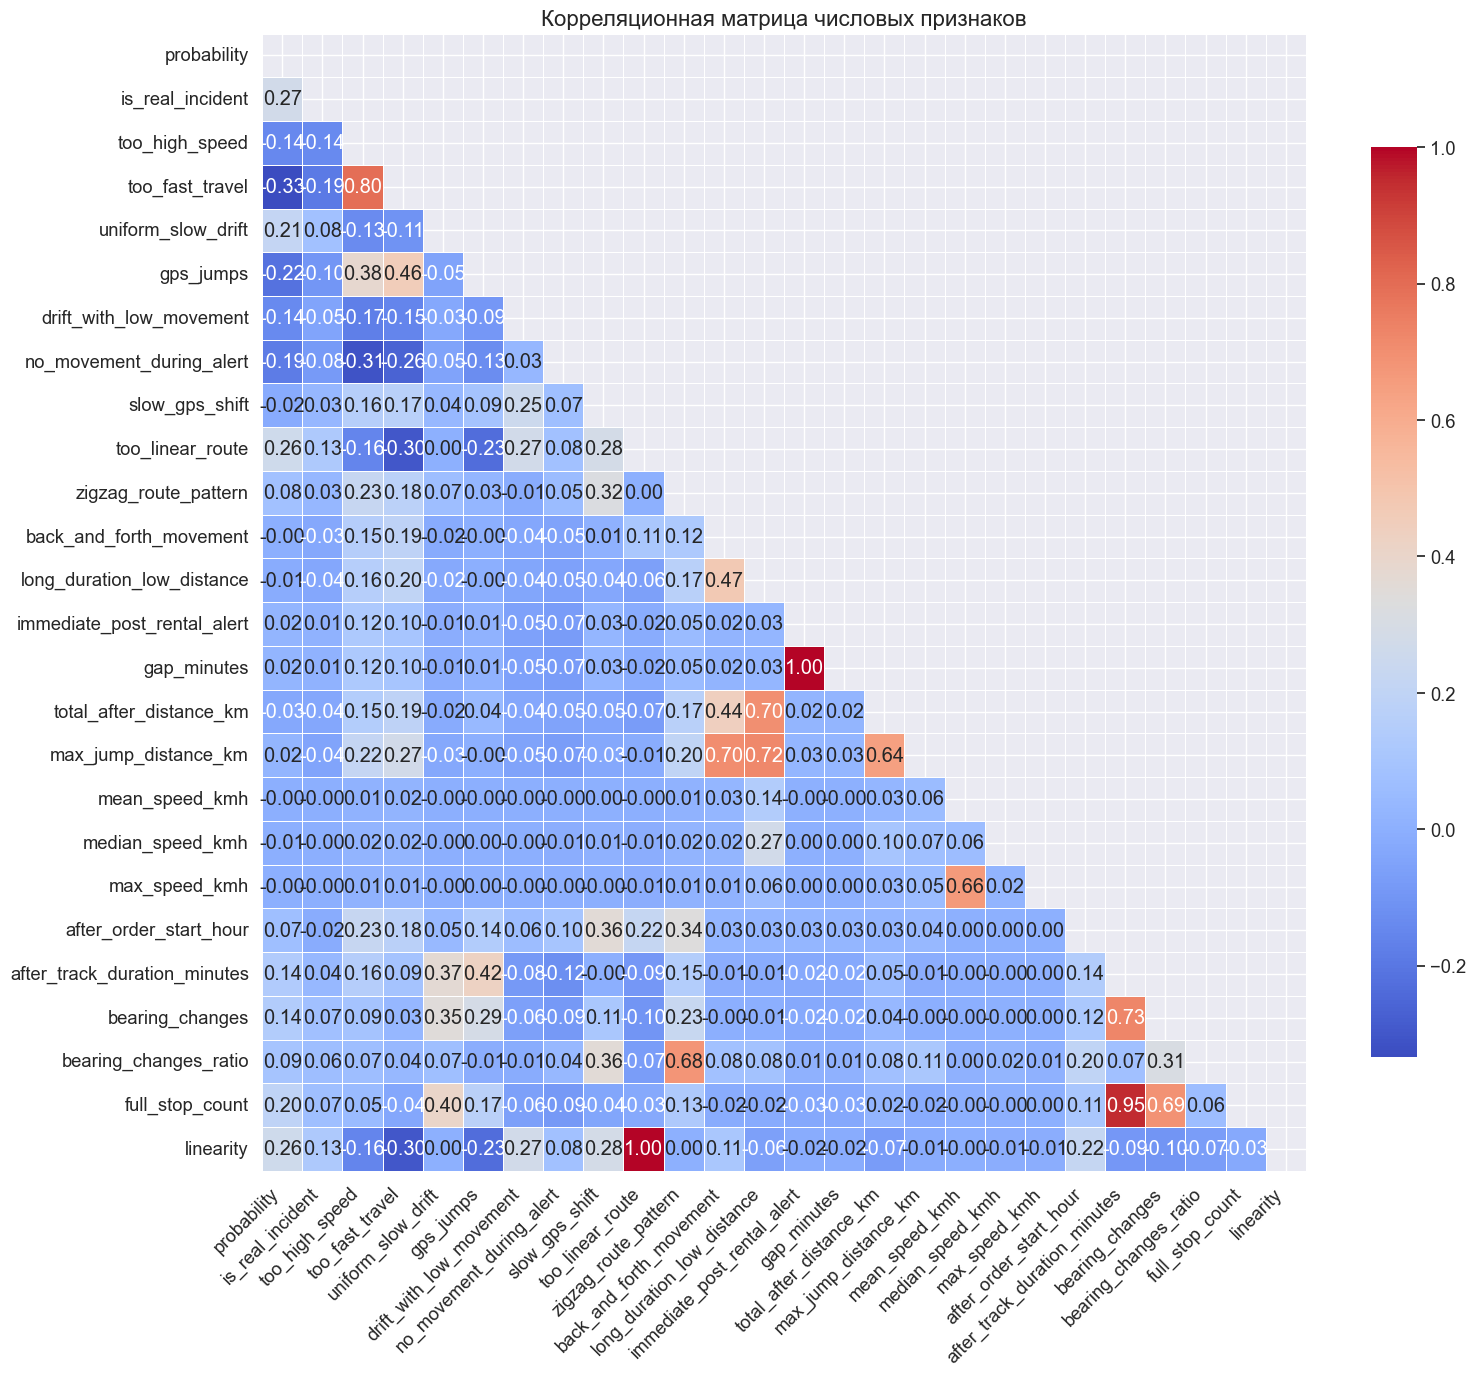

In [39]:
# 7. Анализ корреляций
print("\n7. Анализ корреляций между признаками")

# Построение корреляционной матрицы
plt.figure(figsize=(16, 14))

correlation_matrix = df.select_dtypes(include=['number', 'bool']).corr()

mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица числовых признаков', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
df = df.drop(columns=['too_linear_route', 'gap_minutes'])


8. Анализ связи признаков с целевой переменной

Корреляция признаков с целевой переменной:
is_real_incident                1.000000
probability                     0.273334
too_linear_route                0.129538
linearity                       0.129538
uniform_slow_drift              0.078111
bearing_changes                 0.074782
full_stop_count                 0.067180
bearing_changes_ratio           0.062273
after_track_duration_minutes    0.036556
slow_gps_shift                  0.033960
zigzag_route_pattern            0.031005
gap_minutes                     0.014597
immediate_post_rental_alert     0.014597
max_speed_kmh                  -0.003148
mean_speed_kmh                 -0.003297
median_speed_kmh               -0.004799
after_order_start_hour         -0.015267
back_and_forth_movement        -0.029013
total_after_distance_km        -0.035452
long_duration_low_distance     -0.037142
max_jump_distance_km           -0.043378
drift_with_low_movement        -0.045482
no_mov

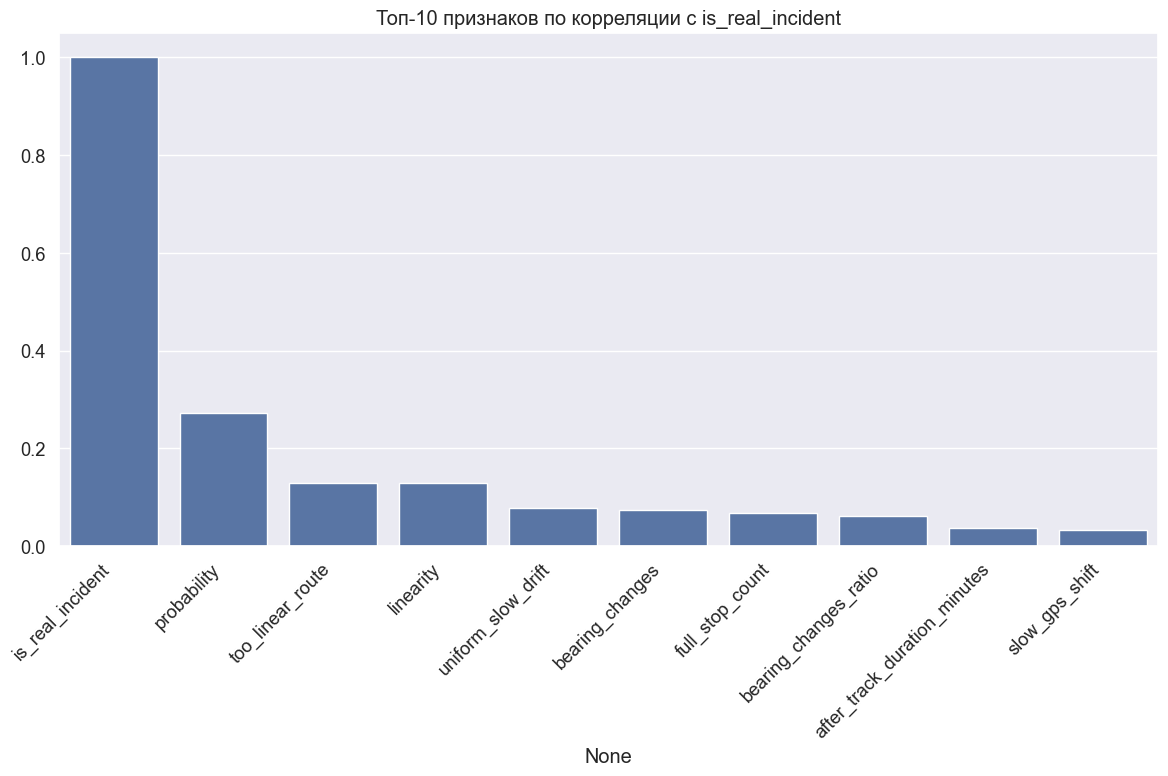

In [40]:
# 8. Связь признаков с целевой переменной
print("\n8. Анализ связи признаков с целевой переменной")

# Расчет корреляции признаков с целевой переменной
target_correlation = correlation_matrix['is_real_incident'].sort_values(ascending=False)
print("\nКорреляция признаков с целевой переменной:")
print(target_correlation)

# Визуализация топ-10 признаков по корреляции с целевой переменной
plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlation.index[:10], y=target_correlation.values[:10])
plt.title('Топ-10 признаков по корреляции с is_real_incident')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# model train

In [137]:
from sklearn.utils import resample

def undersample_data(X, y, ratio=3):
    df = pd.concat([X, y], axis=1)
    majority = df[df[y.name] == 0]
    minority = df[df[y.name] == 1]
    
    n_minority = len(minority)
    n_majority = min(len(majority), ratio * n_minority)

    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=n_majority,
        random_state=42
    )

    df_balanced = pd.concat([majority_downsampled, minority])
    df_balanced = df_balanced.sample(frac=1, random_state=42)  # перемешать

    return df_balanced.drop(columns=[y.name]), df_balanced[y.name]

In [41]:
X = df.drop(['is_real_incident'], axis=1)
y = df['is_real_incident'].astype(int)

In [42]:
X.head()

,probability,too_high_speed,too_fast_travel,uniform_slow_drift,gps_jumps,drift_with_low_movement,no_movement_during_alert,slow_gps_shift,too_linear_route,zigzag_route_pattern,back_and_forth_movement,long_duration_low_distance,immediate_post_rental_alert,gap_minutes,total_after_distance_km,max_jump_distance_km,mean_speed_kmh,median_speed_kmh,max_speed_kmh,after_order_start_hour,after_track_duration_minutes,bearing_changes,bearing_changes_ratio,full_stop_count,linearity
0,70,1,0,0.0,1.0,0.0,0,0.450000,0.561615,1.028840,1497.497149,1.444526,-1.0,-1.0,2.944116,1.200363,4.448138,0.325334,36.637379,17.0,33.968650,1,0.050000,8,0.561615
1,70,0,0,0.0,0.0,0.0,0,0.433962,0.657011,1.013975,1017.310087,0.514100,-1.0,-1.0,1.576814,0.652022,3.638352,0.047069,29.343116,17.0,51.118933,4,0.075472,20,0.657011
2,0,0,0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
3,0,0,0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000
4,0,0,0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0,0.000000,0,0.000000


# Auto ML Подбор порога, Гиперпараметры модели

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# === Метрика с порогом ===
def evaluate_with_threshold(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs > threshold).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # чтобы избежать деления на 0

    return {
        "F1": round(f1, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "Accuracy": round(acc, 4),
        "ROC AUC": round(auc, 4),
        "FNR": round(fnr, 4),
        "Best Threshold": round(threshold, 2),
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    }

# === Подбор порога по максимальному F1 ===
def find_best_threshold(y_true, y_probs):
    best_f1, best_thresh = 0, 0.5
    for thresh in np.arange(0.3, 0.7, 0.01):
        f1 = f1_score(y_true, (y_probs > thresh).astype(int))
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh
    return best_thresh

# === Поиск и оценка ===
def search_and_evaluate(model, param_grid, X, y, search_type='random', n_iter=10, undersample=False, ratio=3):
    # === Андерсемплирование перед разделением на train/test ===
    if undersample:
        X, y = undersample_data(X, y, ratio=ratio)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if search_type == 'random':
        search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, scoring='f1', cv=5, n_jobs=-1, random_state=42, return_train_score=False)
    else:
        search = GridSearchCV(model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, return_train_score=False)

    search.fit(X_train, y_train)

    results = []

    for i in range(len(search.cv_results_["params"])):
        params = search.cv_results_["params"][i]
        current_model = search.estimator.set_params(**params)
        current_model.fit(X_train, y_train)

        y_probs = current_model.predict_proba(X_test)[:, 1]
        best_thresh = find_best_threshold(y_test, y_probs)
        metrics = evaluate_with_threshold(y_test, y_probs, threshold=best_thresh)

        result = {
            "Model": current_model.__class__.__name__,
            "Params": params,
            "Rank (CV)": search.cv_results_["rank_test_score"][i],
            "Mean CV Score (F1)": round(search.cv_results_["mean_test_score"][i], 4),
            "Best Threshold": best_thresh
        }
        result.update(metrics)
        results.append(result)

    return pd.DataFrame(results)




In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

models_params = {
    "XGBClassifier": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "max_depth": [3, 5, 7, 9, 11],
            "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
            "n_estimators": [100, 200, 300, 500],
            "subsample": [0.6, 0.7, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
            "gamma": [0, 0.5, 1, 5],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1],
            "scale_pos_weight": [1, 3, 5, 8]
        }
    },
    "LGBMClassifier": {
        "model": LGBMClassifier(),
        "params": {
            "num_leaves": [20, 31, 50, 70, 100],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "n_estimators": [100, 200, 300, 400],
            "max_depth": [-1, 5, 10, 15],
            "min_child_samples": [5, 10, 20],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1],
            "class_weight": ["balanced", {0:1, 1:3}, {0:1, 1:5}, {0:1, 1:8}]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [5, 10, 15, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False],
            "class_weight": ["balanced", "balanced_subsample", {0:1, 1:3}, {0:1, 1:5}]
        }
    }
}


In [ ]:
best_model

LGBMClassifier(class_weight='balanced', learning_rate=0.01,
               min_child_samples=10, n_estimators=400, num_leaves=10,
               reg_alpha=1, reg_lambda=0, subsample=0.6)

In [46]:
results = []
for model_name, model_cfg in models_params.items():
    res = search_and_evaluate(
        model=model_cfg["model"],
        param_grid=model_cfg["params"],
        X=X,
        y=y,
        search_type='random',
        n_iter=10
    )
    res["Model Name"] = model_name  # добавим колонку, если надо
    results.append(res)

# ⬇️ Объединяем все DataFrame'ы в один
results_df = pd.concat(results, ignore_index=True)

# Сортировка по F1
results_df.sort_values(by="F1", ascending=False, inplace=True)

# Просмотр
print(results_df.head())

/opt/anaconda3/envs/jet_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/jet_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/jet_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/jet_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[LightGBM] [Info] Number of positive: 5150, number of negative: 57215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5136
[LightGBM] [Info] Number of data points in the train set: 62365, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212620 -> initscore=-1.309207
[LightGBM] [Info] Start training from score -1.309207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [47]:
results_df

,Model,Params,Rank (CV),Mean CV Score (F1),Best Threshold,F1,Precision,Recall,Accuracy,ROC AUC,FNR,TN,FP,FN,TP,Model Name
8,XGBClassifier,"{'subsample': 0.7, 'scale_pos_weight': 5, 'reg...",1,0.4346,0.51,0.4603,0.3797,0.5844,0.8821,0.8731,0.4156,16212,1601,697,980,XGBClassifier
4,XGBClassifier,"{'subsample': 1.0, 'scale_pos_weight': 3, 'reg...",6,0.4138,0.43,0.4569,0.3750,0.5844,0.8805,0.8743,0.4156,16180,1633,697,980,XGBClassifier
15,LGBMClassifier,"{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha...",3,0.4226,0.44,0.4558,0.3756,0.5796,0.8809,0.8742,0.4204,16197,1616,705,972,LGBMClassifier
14,LGBMClassifier,"{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha...",4,0.4175,0.42,0.4550,0.3755,0.5772,0.8810,0.8740,0.4228,16203,1610,709,968,LGBMClassifier
16,LGBMClassifier,"{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha...",1,0.4334,0.57,0.4547,0.3774,0.5719,0.8820,0.8736,0.4281,16231,1582,718,959,LGBMClassifier
0,XGBClassifier,"{'subsample': 0.8, 'scale_pos_weight': 3, 'reg...",2,0.4265,0.47,0.4544,0.3927,0.5391,0.8886,0.8744,0.4609,16415,1398,773,904,XGBClassifier
10,LGBMClassifier,"{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha...",6,0.4111,0.45,0.4540,0.3980,0.5283,0.8907,0.8718,0.4717,16473,1340,791,886,LGBMClassifier
21,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 2, ...",1,0.3831,0.37,0.4521,0.3546,0.6237,0.8699,0.8719,0.3763,15909,1904,631,1046,RandomForestClassifier
18,LGBMClassifier,"{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...",2,0.4247,0.46,0.4499,0.3787,0.5540,0.8834,0.8739,0.4460,16289,1524,748,929,LGBMClassifier
5,XGBClassifier,"{'subsample': 0.6, 'scale_pos_weight': 8, 'reg...",7,0.4136,0.67,0.4486,0.3709,0.5677,0.8799,0.8722,0.4323,16198,1615,725,952,XGBClassifier


In [54]:
import pickle

# Шаг 1: Найдём строку с наилучшим F1
best_row = results_df.iloc[0]

# Шаг 2: Получим имя модели и её параметры
best_model_name = best_row["Model Name"]
best_params = best_row["Params"]

# Шаг 3: Создадим и обучим модель заново
best_model = models_params[best_model_name]["model"].set_params(**best_params)
best_model.fit(X, y)  # или X_train, y_train — по твоему выбору

# Шаг 4: Сохраним модель в .pkl
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Модель успешно сохранена в 'best_model.pkl'")


/opt/anaconda3/envs/jet_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:22:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Модель успешно сохранена в 'best_model.pkl'


In [55]:
best_model_name

'XGBClassifier'

In [56]:
X.columns

Index(['probability', 'too_high_speed', 'too_fast_travel',
       'uniform_slow_drift', 'gps_jumps', 'drift_with_low_movement',
       'no_movement_during_alert', 'slow_gps_shift', 'too_linear_route',
       'zigzag_route_pattern', 'back_and_forth_movement',
       'long_duration_low_distance', 'immediate_post_rental_alert',
       'gap_minutes', 'total_after_distance_km', 'max_jump_distance_km',
       'mean_speed_kmh', 'median_speed_kmh', 'max_speed_kmh',
       'after_order_start_hour', 'after_track_duration_minutes',
       'bearing_changes', 'bearing_changes_ratio', 'full_stop_count',
       'linearity'],
      dtype='object')

In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97447 entries, 0 to 97446
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   probability                   97447 non-null  int64  
 1   too_high_speed                97447 non-null  int64  
 2   too_fast_travel               97447 non-null  int64  
 3   uniform_slow_drift            97447 non-null  float64
 4   gps_jumps                     97447 non-null  float64
 5   drift_with_low_movement       97447 non-null  float64
 6   no_movement_during_alert      97447 non-null  int64  
 7   slow_gps_shift                97447 non-null  float64
 8   too_linear_route              97447 non-null  float64
 9   zigzag_route_pattern          97447 non-null  float64
 10  back_and_forth_movement       97447 non-null  float64
 11  long_duration_low_distance    97447 non-null  float64
 12  immediate_post_rental_alert   97447 non-null  float64
 13  g

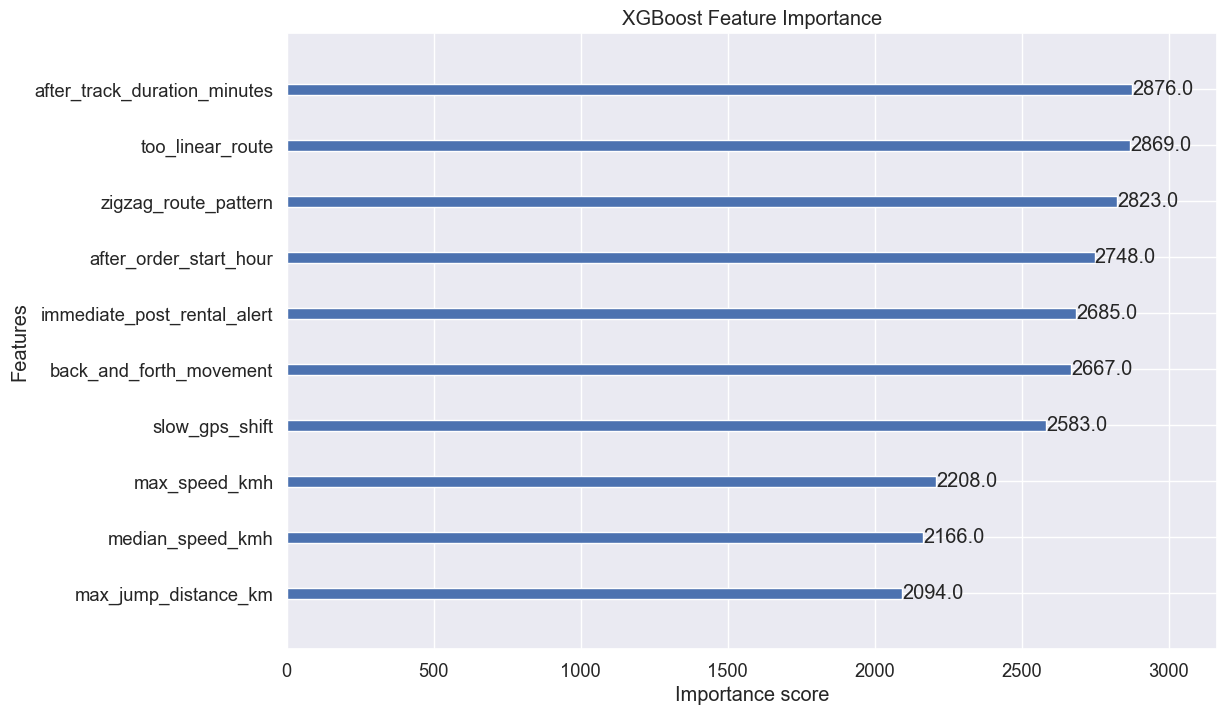

In [60]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Предполагаем, что best_model — обученный XGBClassifier
plot_importance(best_model, max_num_features=10, importance_type='weight')  # или 'gain', 'cover'
plt.title("XGBoost Feature Importance")
plt.show()


In [62]:
df.to_csv('data/perfectly_clean_data.csv')

In [1]:
import pandas as pd

In [2]:
df_new_data = pd.read_csv('data/incidents.csv')

In [3]:
df_new_data.tail()

,id,timestamp,probability,data,alarm_id,tracker_id,business_status,status,incident_group,group_timestamp,user_id,probability_v2
111064,121069,2025-03-28 18:02:24.032091,4,"{'alarm_id': '67e6e42e0753113d7f8c6207', 'iden...",67e6e42e0753113d7f8c6207,S.490574,NaN,pending,NaN,NaN,NaN,NaN
111065,121070,2025-03-28 18:02:39.365711,4,"{'alarm_id': '67e6e43ebe5d625ca237caa6', 'iden...",67e6e43ebe5d625ca237caa6,S.488204,NaN,pending,NaN,NaN,NaN,NaN
111066,121071,2025-03-28 18:02:39.414756,0,"{'alarm_id': '67e6e43d145a6f564960858b', 'iden...",67e6e43d145a6f564960858b,S.449150,NaN,pending,NaN,NaN,NaN,NaN
111067,121072,2025-03-28 18:02:45.896588,7,"{'alarm_id': '67e6e4440753113d7f8c6ffc', 'iden...",67e6e4440753113d7f8c6ffc,S.401385,NaN,pending,NaN,NaN,NaN,NaN
111068,121073,2025-03-28 18:02:49.170954,2,"{'alarm_id': '67e6e448e021a37a0c66451b', 'iden...",67e6e448e021a37a0c66451b,S.036179,NaN,pending,NaN,NaN,NaN,NaN


In [4]:
df_new_data.head()

,id,timestamp,probability,data,alarm_id,tracker_id,business_status,status,incident_group,group_timestamp,user_id,probability_v2
0,10001,2025-02-28 18:33:41.004971,70,"{'alarm_id': '67c20183080e3b4c2ce79b3d', 'iden...",67c20183080e3b4c2ce79b3d,S.268766,Investigation,pending,NaN,NaN,NaN,NaN
1,10002,2025-02-28 18:34:42.401621,70,"{'alarm_id': '67c201bf912cd7c87bf73228', 'iden...",67c201bf912cd7c87bf73228,S.239855,Investigation,pending,NaN,NaN,NaN,NaN
2,10003,2025-02-28 18:36:56.400598,0,"{'alarm_id': '67c2024441519d9b6e46affb', 'iden...",67c2024441519d9b6e46affb,S.281155,NaN,pending,NaN,NaN,NaN,NaN
3,10004,2025-02-28 18:38:26.582477,0,"{'alarm_id': '67c2029e662ce39da73f9ed7', 'iden...",67c2029e662ce39da73f9ed7,S.235144,NaN,pending,NaN,NaN,NaN,NaN
4,10005,2025-02-28 18:38:55.197422,0,"{'alarm_id': '67c202bd41519d9b6e46c3a6', 'iden...",67c202bd41519d9b6e46c3a6,S.480050,NaN,pending,NaN,NaN,NaN,NaN


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

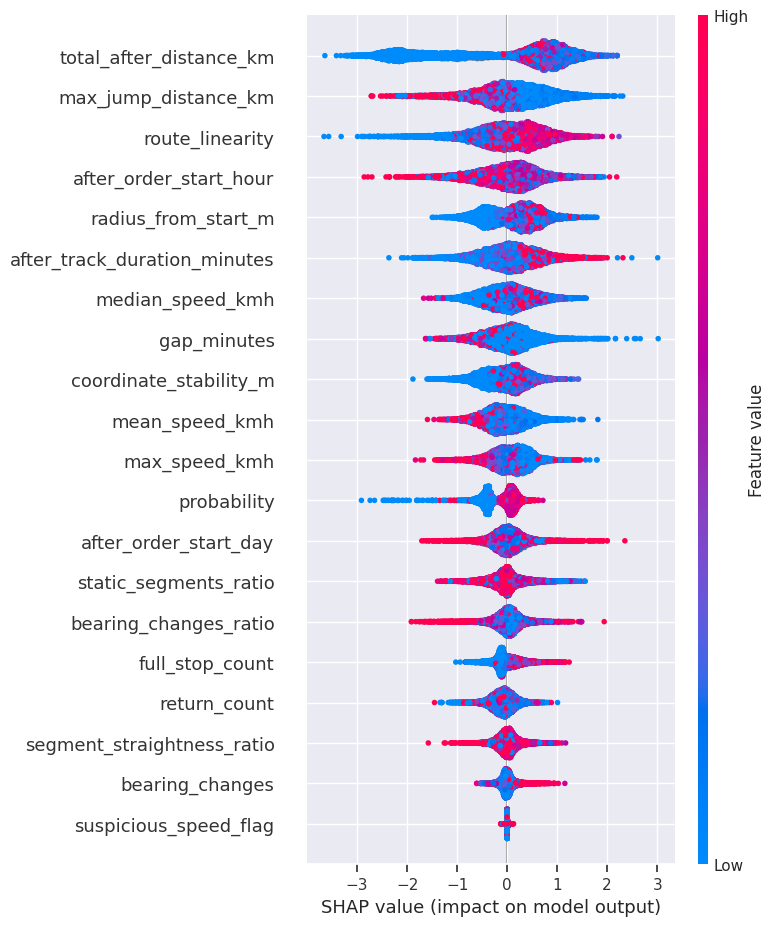

In [ ]:
import shap

# Создаем объект Explainer для вашей модели
explainer = shap.Explainer(best_model)

# Генерируем значения SHAP для тестовых данных
shap_values = explainer(X_test)

# Визуализация важности признаков с помощью SHAP
shap.summary_plot(shap_values, X_test)

In [ ]:
import plotly.express as px
import pandas as pd

# Получаем важность признаков
importance = best_model.feature_importances_
features = X_train.columns

# Создаем DataFrame для визуализации
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

# Визуализация через Plotly
fig = px.bar(feature_importance_df, x='importance', y='feature', orientation='h')
fig.update_layout(title="Feature Importance", xaxis_title="Importance", yaxis_title="Feature")
fig.show()

In [ ]:
feature_importance_df[feature_importance_df['importance'] > 500]['feature']

,feature
16,route_linearity
1,gap_minutes
6,max_speed_kmh
10,after_order_start_hour
11,after_track_duration_minutes
2,max_jump_distance_km
4,mean_speed_kmh
3,total_after_distance_km
8,bearing_changes_ratio
5,median_speed_kmh


In [ ]:
feature_importance_df[feature_importance_df['importance'] > 500]['feature'].values

array(['route_linearity', 'gap_minutes', 'max_speed_kmh',
       'after_order_start_hour', 'after_track_duration_minutes',
       'max_jump_distance_km', 'mean_speed_kmh',
       'total_after_distance_km', 'bearing_changes_ratio',
       'median_speed_kmh', 'radius_from_start_m',
       'coordinate_stability_m', 'static_segments_ratio',
       'segment_straightness_ratio', 'after_order_start_day',
       'return_count', 'probability', 'full_stop_count',
       'bearing_changes'], dtype=object)

In [ ]:
features

array(['route_linearity', 'gap_minutes', 'max_speed_kmh',
       'after_order_start_hour', 'after_track_duration_minutes',
       'max_jump_distance_km', 'mean_speed_kmh',
       'total_after_distance_km', 'bearing_changes_ratio',
       'median_speed_kmh', 'radius_from_start_m',
       'coordinate_stability_m', 'static_segments_ratio',
       'segment_straightness_ratio', 'after_order_start_day',
       'return_count'], dtype=object)

In [ ]:
df_v2 = df[['route_linearity', 'gap_minutes', 'max_speed_kmh',
       'after_order_start_hour', 'after_track_duration_minutes',
       'max_jump_distance_km', 'mean_speed_kmh',
       'total_after_distance_km', 'bearing_changes_ratio',
       'median_speed_kmh', 'radius_from_start_m',
       'coordinate_stability_m', 'static_segments_ratio',
       'segment_straightness_ratio', 'after_order_start_day',
       'return_count', 'is_real_incident',]]

In [ ]:
df_v2.head()

,route_linearity,gap_minutes,max_speed_kmh,after_order_start_hour,after_track_duration_minutes,max_jump_distance_km,mean_speed_kmh,total_after_distance_km,bearing_changes_ratio,median_speed_kmh,radius_from_start_m,coordinate_stability_m,static_segments_ratio,segment_straightness_ratio,after_order_start_day,return_count,is_real_incident
0,0.357348,373.298267,38.957953,16,57.660250,0.377397,4.239456,3.827640,0.083969,0.316323,1367.800788,29.218629,0.496183,0.712617,6.0,21.0,False
1,0.322625,0.040517,11.038868,16,16.416033,1.476528,1.910180,0.029811,0.166667,0.090280,9.617702,4.968458,0.833333,0.000000,6.0,5.0,False
2,0.500446,249.161533,33.409431,16,57.970483,1.476528,1.595331,2.161405,0.038462,0.000000,1081.667436,83.130966,0.923077,0.953734,6.0,24.0,False
3,0.172822,0.133783,0.134603,16,41.883400,0.004575,0.058818,0.041841,0.318182,0.050335,7.231093,1.901875,1.000000,-2.667908,6.0,21.0,False
4,0.565536,474.609117,7.026983,16,57.893167,0.219257,0.379653,0.388714,0.187500,0.092278,219.831846,12.147320,0.937500,-0.543550,6.0,27.0,True


In [ ]:
X_v2 = df_v2.drop(['is_real_incident'], axis=1)
y_v2 = df_v2['is_real_incident'].astype(int)

In [ ]:
results = []
for model_name, model_cfg in models_params.items():
    res = search_and_evaluate(
        model=model_cfg["model"],
        param_grid=model_cfg["params"],
        X=X_v2,
        y=y_v2,
        search_type='random',
        n_iter=10
    )
    res["Model Name"] = model_name  # добавим колонку, если надо
    results.append(res)

# ⬇️ Объединяем все DataFrame'ы в один
results_df = pd.concat(results, ignore_index=True)

# Сортировка по F1
results_df.sort_values(by="F1", ascending=False, inplace=True)

# Просмотр
print(results_df.head())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:52:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:52:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:52:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:52:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:52:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:52:16] WARNING: /workspace

[LightGBM] [Info] Number of positive: 7062, number of negative: 37399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3406
[LightGBM] [Info] Number of data points in the train set: 44461, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.361628 -> initscore=-0.568303
[LightGBM] [Info] Start training from score -0.568303
[LightGBM] [Info] Number of positive: 7062, number of negative: 37399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3406
[LightGBM] [Info] Number of data points in the train set: 44461, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Lig

In [ ]:
results_df

In [ ]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Artsem's part

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
with open("/content/best_model.pkl", "rb") as f:
  best_model = pickle.load(f)

EOFError: Ran out of input

In [ ]:
best_model.params

NameError: name 'best_model' is not defined

In [ ]:
# with open('#.pkl', 'rb') as f:
#      # = pickle.load(f)


